<h1><center> Time Series </center></h1>

## Imports

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.mlab as mlab
import math
from scipy.stats import norm
import statsmodels.graphics.tsaplots as tsa
from statsmodels.tsa.ar_model import AR
from random import random

## Download the data

In [183]:
df = pd.read_csv("sea_ice.csv")

In [184]:
df.head()

,Time,Arctic,Antarctica
0,1990M01,12.72,3.27
1,1990M02,13.33,2.15
2,1990M03,13.44,2.71
3,1990M04,12.16,5.10
4,1990M05,10.84,7.37


In [185]:
df.isnull().sum()

Time          0
Arctic        0
Antarctica    0
dtype: int64

In [186]:
df.index = pd.to_datetime(df['Time'].str.replace("M", "-"))

In [187]:
df = df.drop(['Time', 'Arctic'], axis=1)

In [188]:
df.head()

,Antarctica
Time,
1990-01-01,3.27
1990-02-01,2.15
1990-03-01,2.71
1990-04-01,5.10
1990-05-01,7.37


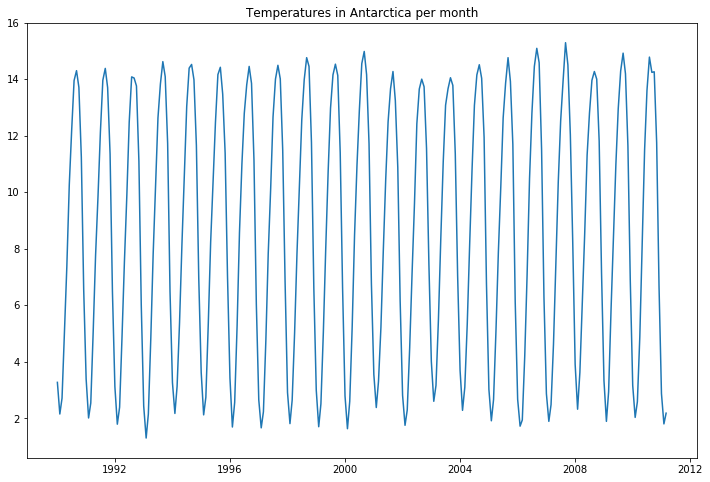

In [189]:
plt.figure(figsize=(12,8))
plt.plot(df['Antarctica'])
plt.title("Temperatures in Antarctica per month")
plt.show()

## Test the stationarity

In [190]:
from statsmodels.tsa.stattools import adfuller
rolmean = df['Antarctica'].rolling(12).mean()

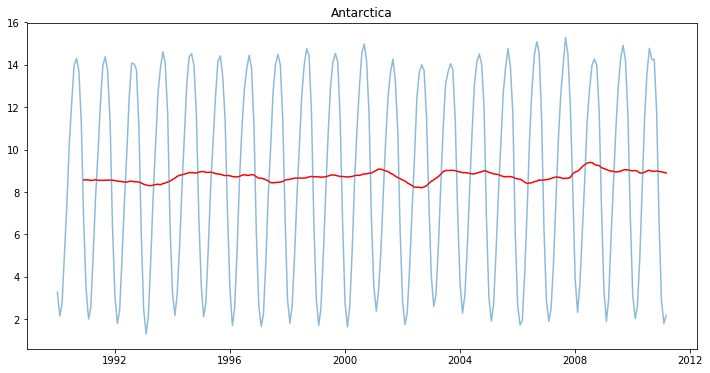

In [191]:
plt.figure(figsize=(12,6))
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(df['Antarctica'], alpha=0.5)
plt.title("Antarctica")
plt.show()

The rolling mean cannot match the process which is not stationary.

## Create Stationarity

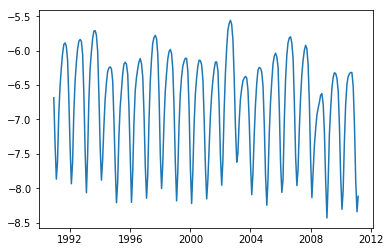

In [194]:
plt.plot(np.log(df['Antarctica']) - rolmean)

## Linear Model with Extracted Features

In [69]:
X = df.copy()

### Create the features

In [111]:
n_harm = 20

In [112]:
for k in range(1, n_harm) :
    X['add_cos' + str(k)] = np.cos(X['index'] * k * 2 * math.pi / 365)
    X['add_sin' + str(k)] = np.sin(X['index'] * k * 2 * math.pi / 365)

In [113]:
X.head()

,IAS_brut,index,add_cos0,add_sin0,add_cos1,add_sin1,add_cos2,add_sin2,add_cos3,add_sin3,...,add_cos45,add_sin45,add_cos46,add_sin46,add_cos47,add_sin47,add_cos48,add_sin48,add_cos49,add_sin49
PERIODE,,,,,,,,,,,,,,,,,,,,,
2009-07-01,1.7,0,1.0,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
2009-07-02,3.4,1,1.0,0.0,0.999852,0.017213,0.999407,0.034422,0.998667,0.051620,...,0.714673,0.699458,0.702527,0.711657,0.690173,0.723644,0.677615,0.735417,0.664855,0.746972
2009-07-03,2.1,2,1.0,0.0,0.999407,0.034422,0.997630,0.068802,0.994671,0.103102,...,0.021516,0.999769,-0.012910,0.999917,-0.047321,0.998880,-0.081676,0.996659,-0.115935,0.993257
2009-07-04,1.3,3,1.0,0.0,0.998667,0.051620,0.994671,0.103102,0.988023,0.154309,...,-0.683919,0.729558,-0.720667,0.693281,-0.755493,0.655156,-0.788305,0.615285,-0.819015,0.573772
2009-07-05,14.2,4,1.0,0.0,0.997630,0.068802,0.990532,0.137279,0.978740,0.205104,...,-0.999074,0.043022,-0.999667,-0.025818,-0.995521,-0.094537,-0.986658,-0.162807,-0.973118,-0.230306


In [114]:
X_train = X[X.index < "2013-03-31"].drop(['index', 'IAS_brut'], axis=1)
X_test = X[X.index >= "2013-03-31"].drop(['index', 'IAS_brut'], axis=1)

In [115]:
y_train = X[X.index < "2013-03-31"]['IAS_brut']
y_test = X[X.index >= "2013-03-31"]['IAS_brut']

### Fit the model

In [116]:
est = sm.OLS(y_train, X_train).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               IAS_brut   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.200
Date:                Mon, 21 Jan 2019   Prob (F-statistic):             0.0965
Time:                        00:22:27   Log-Likelihood:                -12887.
No. Observations:                1369   AIC:                         2.597e+04
Df Residuals:                    1270   BIC:                         2.649e+04
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
add_cos0     366.6262     83.829      4.373      0.0

In [117]:
pred = est.predict(X_test)
pred.head()

PERIODE
2013-03-31   -216.803046
2013-04-01   -249.909598
2013-04-02   -121.366113
2013-04-03     80.346691
2013-04-04    223.223977
dtype: float64

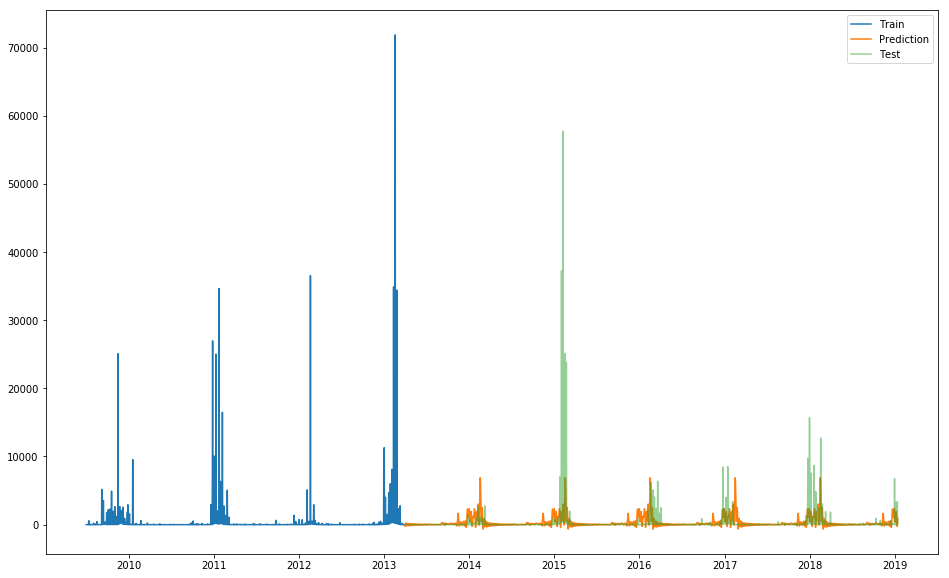

In [118]:
plt.figure(figsize=(16,10))
plt.plot(y_train, label="Train")
plt.plot(pred, label="Prediction")
plt.plot(y_test, label="Test", alpha=0.5)
plt.legend()
plt.show()

### Hyper-Parameter tuning

In [119]:
df.head()

,IAS_brut,index
PERIODE,,
2009-07-01,1.7,0
2009-07-02,3.4,1
2009-07-03,2.1,2
2009-07-04,1.3,3
2009-07-05,14.2,4


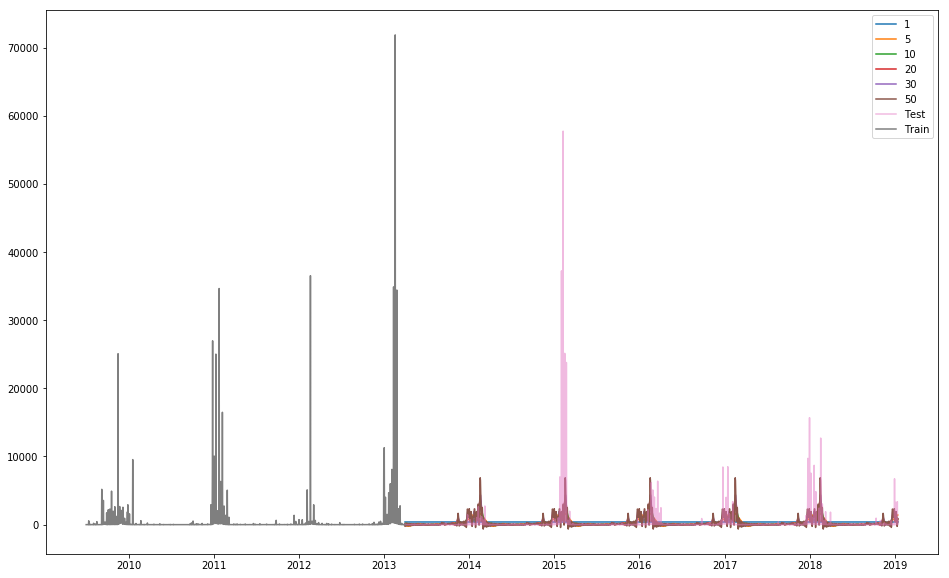

In [107]:
plt.figure(figsize=(16,10))

for n_harm in [1,5,10,20,30,50] :
    X = df.copy()
    for k in range(n_harm) :
        X['add_cos' + str(k)] = np.cos(X['index'] * k * 2 * math.pi / 365)
        X['add_sin' + str(k)] = np.sin(X['index'] * k * 2 * math.pi / 365)
    X_train = X[X.index < "2013-03-31"].drop(['index', 'IAS_brut'], axis=1)
    X_test = X[X.index >= "2013-03-31"].drop(['index', 'IAS_brut'], axis=1)
    y_train = X[X.index < "2013-03-31"]['IAS_brut']
    y_test = X[X.index >= "2013-03-31"]['IAS_brut']
    est = sm.OLS(y_train, X_train).fit()
    pred = est.predict(X_test)
    plt.plot(pred, label=str(n_harm))
        
plt.plot(y_test, label="Test", alpha=0.5)
plt.plot(y_train, label="Train")
plt.legend()
plt.show()

## AR(p) Model

In [122]:
X = df.copy()
X_train = X[X.index < "2013-03-31"]
X_test = X[X.index >= "2013-03-31"]

In [125]:
# fit model
ar = AR(X_train['IAS_brut'])
ar = ar.fit()
# make prediction
yhat = ar.predict(start="2013-03-31", end="2018-12-31")

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


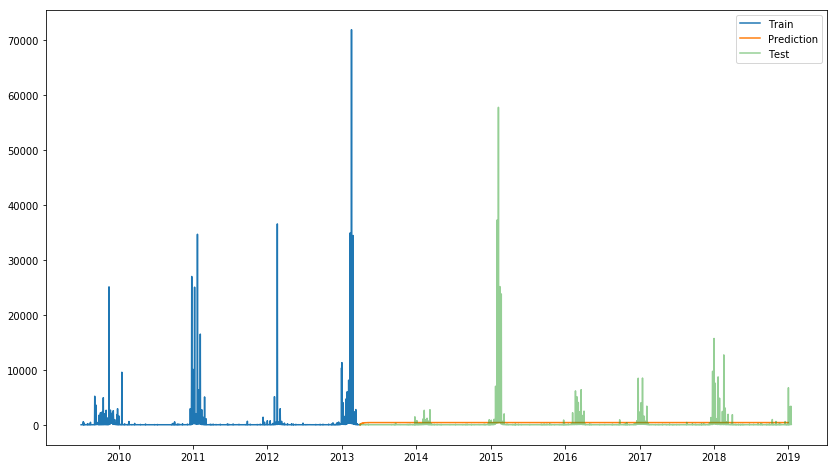

In [126]:
plt.figure(figsize=(14,8))
plt.plot(X_train['IAS_brut'], label="Train")
plt.plot(yhat, label="Prediction")
plt.plot(X_test['IAS_brut'], label="Test", alpha=0.5)
plt.legend()
plt.show()

## ARMA(p,q) Model

In [137]:
arma = ARMA(X_train['IAS_brut'], order=(10,2))
arma = arma.fit()
yhat = arma.predict(start="2013-03-31", end="2018-12-31")

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


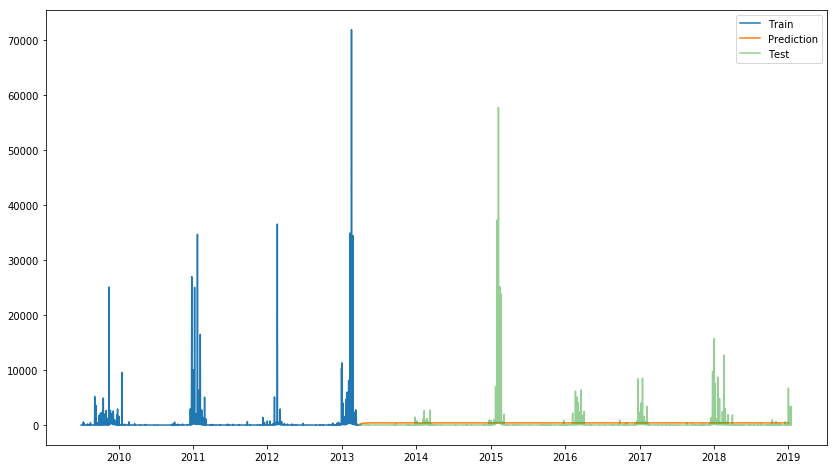

In [138]:
plt.figure(figsize=(14,8))
plt.plot(X_train['IAS_brut'], label="Train")
plt.plot(yhat, label="Prediction")
plt.plot(X_test['IAS_brut'], label="Test", alpha=0.5)
plt.legend()
plt.show()

In [ ]:
## 

In [139]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(X_train['IAS_brut'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [140]:
yhat = model_fit.predict(start="2013-03-31", end="2018-12-31")

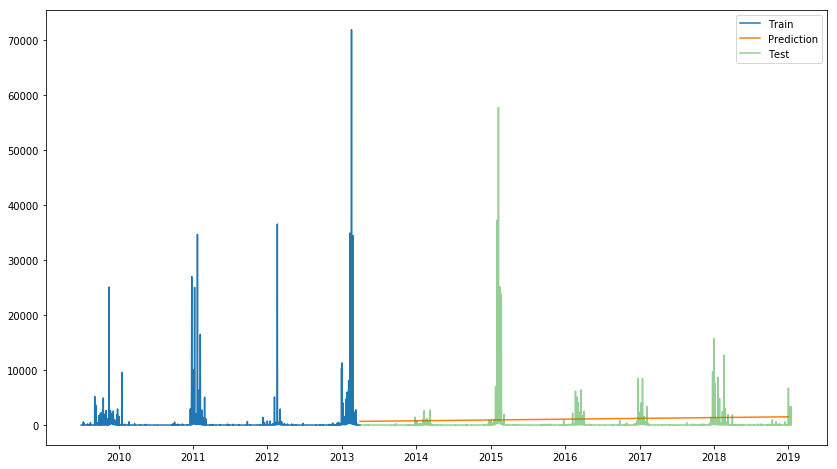

In [141]:
plt.figure(figsize=(14,8))
plt.plot(X_train['IAS_brut'], label="Train")
plt.plot(yhat, label="Prediction")
plt.plot(X_test['IAS_brut'], label="Test", alpha=0.5)
plt.legend()
plt.show()